In [1]:
import treeswift
from utils import *
import random
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
from pathlib import Path
from datetime import datetime, timedelta as dt, timedelta
import datetime
from collections import Counter
import time
import numpy.random as rng
%matplotlib inline

# Primary analysis (3.47-day doubling time, 15% ascertainment rate) tree sizes

In [2]:
clade_analyses_CC_dir = '../FAVITES-COVID-Lite/cumulative_results/clade_analyses_CC/'
clade_analyses_AB_dir = '../FAVITES-COVID-Lite/cumulative_results/clade_analyses_AB/'

In [3]:
#clade_analyses_CC_dir = '0.28TF/clade_analyses_CC/'
#clade_analyses_AB_dir = '0.28TF/clade_analyses_AB/'

In [4]:
clade_analyses_CC_d = dict()
for path in sorted(os.listdir(clade_analyses_CC_dir)): # pool all C/C clade analyses together 
    clade_analysis_path = clade_analyses_CC_dir + path
    key = path.split('_')[0]
    num_taxa = 0
    for line in open(clade_analysis_path):
        l = line.strip().strip(']').split('[')
        clade_size = int(l[0].strip()) # make each clade size (including single leaves) an integer
        num_taxa += clade_size
    clade_analyses_CC_d[key] = num_taxa
clade_analyses_CC_d = {int(k):clade_analyses_CC_d[k] for k in clade_analyses_CC_d}    
clade_analyses_CC_sizes = list(clade_analyses_CC_d.values())

print('Less than 787 taxa: %f' % (sum([x < 787 for x in clade_analyses_CC_sizes])/1100))
print('More than 1000 taxa: %f' % (sum([x > 1000 for x in clade_analyses_CC_sizes])/1100))
print('More than 5000 taxa: %f' % (sum([x > 5000 for x in clade_analyses_CC_sizes])/1100))

Less than 787 taxa: 0.014545
More than 1000 taxa: 0.983636
More than 5000 taxa: 0.967273


# Tree shapes and bayes factors

In [5]:
unconstrained_results = np.array([1.68,80.85, 10.32, 0.92])/100 # linB, linA, C/C, T/T
recCA_results = np.array([77.28, 8.18, 10.49, 3.71])/100 # linB, linA, C/C, T/T

In [6]:
def calculate_bf(asr_results, simulation_results):
    # Let t_p be a polytomy, t_1C be one clade, and t_2c be two clades
    # trees are in the order
    # (t_p, t_1C, t_2C, (t_p,(t_p,t_1C,t_2C)), (t_1C,(t_p,t_1C,t_2C)), (t_2c,(t_p,t_1C,t_2C)))
    compatibility_matrix = np.array([np.array([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]), \
                                     np.array([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]),  \
                                     np.array([0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]),  \
                                     np.array([0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0])]  \
                                    )
    # A matrix of conditional probabilities
    # Each row stores the vector Pr(S_MRCA | \btau)
    pr_s_mrca_given_tree = compatibility_matrix.T
    pr_s_mrca_given_tree = np.array([x/sum(x) if sum(x) > 0 else x for x in pr_s_mrca_given_tree]) # if tree not associated with any haplotype, just keep the row as all 0s
    
    # Order: S_A, S_B, S_{C/C}, S_{T/T}
    pr_s_mrca_given_data = np.array(asr_results)/sum(asr_results)
    unnormalized_pr_data_given_s_mrca = pr_s_mrca_given_data.copy()
    
    # FAVITES simulation information
    # the 3 trees are in the order (t_p, t_1C, t_2C)
    pr_3_topos = np.array(simulation_results)/sum(simulation_results)
    pr_trees_given_I1 = np.concatenate([pr_3_topos, np.array([0]*9)])
    pr_trees_given_I2 = np.concatenate([np.array([0]*3), np.outer(pr_3_topos, pr_3_topos).flatten()])
    
    # Equal prior probability of 1 or 2 intros
    pr_I1 = 0.5
    pr_I2 = 0.5
    
    pr_s_mrca_and_I1 = np.dot([np.dot(pr_s_mrca_given_tree.T[i], pr_trees_given_I1) for i in range(0,4)], pr_I1) # dot product of P(haplotype|tree) (column) and P(trees|I_n), scaled by P(I_n)
    pr_s_mrca_and_I2 = np.dot([np.dot(pr_s_mrca_given_tree.T[i], pr_trees_given_I2) for i in range(0,4)], pr_I2)
    
    posterior_odds = np.dot(unnormalized_pr_data_given_s_mrca, pr_s_mrca_and_I2) / np.dot(unnormalized_pr_data_given_s_mrca, pr_s_mrca_and_I1)
    prior_odds = pr_I2/pr_I1
    BF = posterior_odds/prior_odds

    return(BF)
    
    

In [7]:
def clade_analysis_updated(clade_analyses_CC_dir, clade_analyses_AB_dir, label, min_polytomy_size=100, _print_=False):
    
    # C/C analyses focus on 1-mutation clades
    # therefore, all descendant lineages are included:
    #   -1 = unmutated leaf
    #    1 = mutated leaf separate from a clade
    #   >1 = clade
    clade_analyses_CC_d = dict()
    assert len(os.listdir(clade_analyses_CC_dir))>0, f"no files in {clade_analyses_CC_dir}" 
    for path in sorted(os.listdir(clade_analyses_CC_dir)): # pool all C/C clade analyses together 
        clade_analysis_path = clade_analyses_CC_dir + path
        key = path.split('_')[0]
        clade_analyses_CC_d[key] = {'clade_sizes': [], 'subclade_sizes': []}
        assert os.path.isfile(clade_analysis_path), f"{clade_analysis_path} doesn't exist" 
        for line in open(clade_analysis_path):
            l = line.strip().strip(']').split('[')
            clade_size = int(l[0].strip()) # make each clade size (including single leaves) an integer
            subclade_sizes = [int(x) for x in l[1].strip().replace(' ', '').split(',')] # put each subclade size (including single leaves) into a list        
            clade_analyses_CC_d[key]['clade_sizes'].append(clade_size)
            clade_analyses_CC_d[key]['subclade_sizes'].append(subclade_sizes)
    clade_analyses_CC_d = {int(k):clade_analyses_CC_d[k] for k in clade_analyses_CC_d}    

    # A/B analyses focus on 2-mutation clades
    # only 2-mutation clades are included 
    clade_analyses_AB_d = dict()
    for path in sorted(os.listdir(clade_analyses_AB_dir)): # pool all A/B clade analyses together 
        clade_analysis_path = clade_analyses_AB_dir + path
        key = path.split('_')[0]
        clade_analyses_AB_d[key] = {'clade_sizes': [], 'subclade_sizes': []}
        for line in open(clade_analysis_path):
            l = line.strip().strip(']').split('[')
            clade_size = int(l[0].strip()) # make each clade size (including single leaves) an integer
            subclade_sizes = [int(x) for x in l[1].strip().replace(' ', '').split(',')] # put each subclade size (including single leaves) into a list        
            clade_analyses_AB_d[key]['clade_sizes'].append(clade_size)
            clade_analyses_AB_d[key]['subclade_sizes'].append(subclade_sizes)
    clade_analyses_AB_d = {int(k):clade_analyses_AB_d[k] for k in clade_analyses_AB_d}    
    
    
    # C/C analysis
    cc_count = 0 # how often are there only two 1-mutation clades and no other descendants from the root?
    cc_count_1perc = 0 # how often are there only two 1-mutation clades, each constituting more than 1% of taxa, and no other descendants from the root?
    cc_count_30perc = 0 # how often are there only two 1-mutation clades, each constituting more than 30% of taxa, and no other descendants from the root?
    cc_count_30perc_twoPolytomies = 0 # how often are there only two 1-mutation clades, each constituting more than 30% of taxa AND with a polytomy at the base of each clade, and no other descendants from the root?
    for run in clade_analyses_CC_d:
        clade_sizes = clade_analyses_CC_d[run]['clade_sizes'].copy()
        subclade_sizes = [len(x)>=min_polytomy_size for x in clade_analyses_CC_d[run]['subclade_sizes'].copy()]
        if len(clade_sizes) == 2: # if there are more than two descendants, including individual leaves, skip
            if sum([clade_size > 1 for clade_size in clade_sizes]) == 2: # make sure each clade is an actual clade
                cc_count += 1
                if min(clade_sizes) > (sum(clade_sizes)*0.01): # make sure each clade is >1%
                    cc_count_1perc += 1
                if min(clade_sizes) > (sum(clade_sizes)*0.30): # make sure each clade is >30%
                    cc_count_30perc += 1
                    # does the clade have a polytomy at the base? 
                    if False not in subclade_sizes:
                        cc_count_30perc_twoPolytomies += 1
    
    # A/B analysis
    ab_count_30perc = 0 # interested in 2 mutations clade that are at least 30% of all taxa
    ab_count_30perc_polytomy = 0 # interested in 2 mutations clade that are at least 30% of all taxa + has a basal polytomy
    ab_count_30perc_twoPolytomies = 0 # interested in 2 mutations clade that are at least 30% of all taxa + has a basal polytomy + polytomy at 2 mutation clade
    lower_constraint = 0.3 # the 2-mutation clade must be at least 30% of all taxa
    upper_constraint = 0.7 # the 2-mutation clade must be at most 70% of all taxa
    
    for run in clade_analyses_AB_d:
        num_leaves = sum(clade_analyses_CC_d[run]['clade_sizes'])
        base_polytomy_size = len(clade_analyses_CC_d[run]['clade_sizes'])
        clade_sizes = clade_analyses_AB_d[run]['clade_sizes']
        subclade_sizes = clade_analyses_CC_d[run]['subclade_sizes'].copy()
        if not clade_sizes: # no 2 mutation clades
            continue
        if max(clade_sizes) >= lower_constraint*num_leaves and max(clade_sizes) <= upper_constraint*num_leaves: # clades match size restrictions
            if len(clade_sizes) == 1:
                ab_count_30perc += 1
                if base_polytomy_size >= min_polytomy_size: # basal polytomy
                    ab_count_30perc_polytomy += 1
                    if len(subclade_sizes[0]) >= min_polytomy_size: # two-mutation clade has polytomy
                        ab_count_30perc_twoPolytomies += 1
            else:
                clade2 = sorted(clade_sizes, reverse=True)[1]
                ab_count_30perc += 1
                if base_polytomy_size >= min_polytomy_size: # basal polytomy
                    ab_count_30perc_polytomy += 1
                    max2mutCladeLoc = clade_sizes.index(max(clade_sizes))
                    if len(subclade_sizes[max2mutCladeLoc]) >= min_polytomy_size: # two mutation clade has polytomy
                        ab_count_30perc_twoPolytomies += 1

    # polytomy: checking if there is a polytomy at the base of the tree; can do this using the C/C analysis
    min_polytomy_descendants = min_polytomy_size
    count_atLeastMinDescendants = 0
    for run in clade_analyses_CC_d:
        clade_sizes = clade_analyses_CC_d[run]['clade_sizes']
        if len(clade_sizes) >= min_polytomy_descendants: 
            count_atLeastMinDescendants += 1
    polytomy_result = count_atLeastMinDescendants/1100
    
    # calculate bayes factors
    cc_result = cc_count_30perc_twoPolytomies/1100
    ab_result = ab_count_30perc_twoPolytomies/1100
    constraint_text = 'Primary'

    simulation_results = [polytomy_result, ab_result, cc_result]
    unconstrained_results = np.array([1.68, 80.85, 10.32, 0.92])/100 # linA, linB, C/C, T/T
    recCA_results = np.array([77.28, 8.18, 10.49, 3.71])/100 # linA, linB, C/C, T/T
    bf_unconstrained = calculate_bf(unconstrained_results, simulation_results)
    bf_recCA = calculate_bf(recCA_results, simulation_results)
    
    if _print_ == True:
        print('Proportion with a polytomy at the base: %f\n' % (count_atLeastMinDescendants/1100))
        print('C/C clade analysis: \n\tGeneral result: %f\n\t1%% min clade size: %f\n\t30%% min clade size: %f\n\tAnd polytomy at base of each clade: %f\n' % (cc_count/1100, cc_count_1perc/1100, cc_count_30perc/1100, cc_count_30perc_twoPolytomies/1100))
        print('A/B clade analysis:\n\tGeneral result: %f\n\tWith basal polytomy: %f\n\tAnd with polytomy at 2-mut clade: %f\n' % (ab_count_30perc/1100, ab_count_30perc_polytomy/1100, ab_count_30perc_twoPolytomies/1100))
        print('Unconstrained Bayes factor: %f' % bf_unconstrained)
        print('recCA Bayes factor: %f' % bf_recCA)

    return [label, min_polytomy_size, "{:.1f}".format(cc_result*100), "{:.1f}".format(ab_result*100), "{:.1f}".format(polytomy_result*100), "{:.1f}".format(bf_unconstrained), "{:.1f}".format(bf_recCA)]
    

### Main result

In [8]:
# 3.5DT 

In [9]:
results = clade_analysis_updated(clade_analyses_CC_dir, clade_analyses_AB_dir, '3.5 DT', min_polytomy_size=100, _print_=True)

Proportion with a polytomy at the base: 0.475455

C/C clade analysis: 
	General result: 0.105455
	1% min clade size: 0.067273
	30% min clade size: 0.014545
	And polytomy at base of each clade: 0.000000

A/B clade analysis:
	General result: 0.108182
	With basal polytomy: 0.040909
	And with polytomy at 2-mut clade: 0.004545

Unconstrained Bayes factor: 59.990985
recCA Bayes factor: 61.573227


### Comapre against original

We see that the result is exactly the same as in the [original notebook by Pekar et al.](https://github.com/sars-cov-2-origins/multi-introduction/blob/main/notebooks/cladeAnalysis.ipynb) 

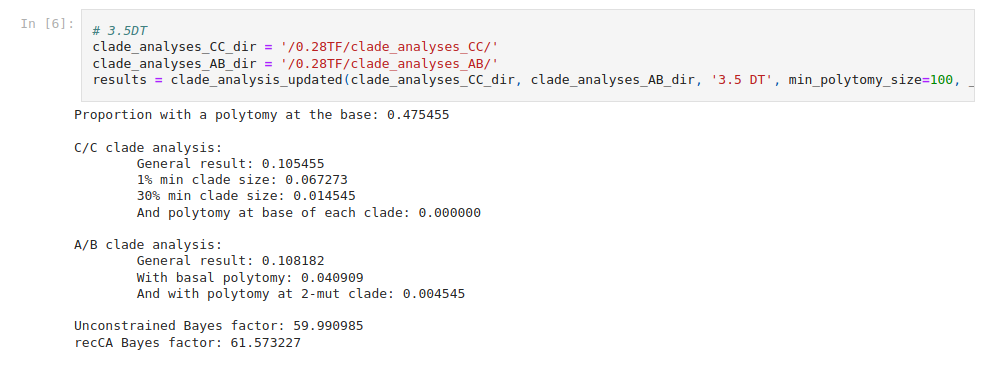

In [10]:
from IPython.display import Image
Image("../images/main-cladeAnalysis_cell6.png")

### All results

### Generate table

In [11]:
# pooled_df.to_csv('bayes_factors.csv', index=None)

## Correction to subclade sizes

subclade_sizes corrected to use the two-mutation list

In [12]:
def clade_analysis_corrected(clade_analyses_CC_dir, clade_analyses_AB_dir, label, min_polytomy_size=100, _print_=False):
    
    # C/C analyses focus on 1-mutation clades
    # therefore, all descendant lineages are included:
    #   -1 = unmutated leaf
    #    1 = mutated leaf separate from a clade
    #   >1 = clade
    clade_analyses_CC_d = dict()
    assert len(os.listdir(clade_analyses_CC_dir))>0, f"no files in {clade_analyses_CC_dir}" 
    for path in sorted(os.listdir(clade_analyses_CC_dir)): # pool all C/C clade analyses together 
        clade_analysis_path = clade_analyses_CC_dir + path
        key = path.split('_')[0]
        clade_analyses_CC_d[key] = {'clade_sizes': [], 'subclade_sizes': []}
        assert os.path.isfile(clade_analysis_path), f"{clade_analysis_path} doesn't exist" 
        for line in open(clade_analysis_path):
            l = line.strip().strip(']').split('[')
            clade_size = int(l[0].strip()) # make each clade size (including single leaves) an integer
            subclade_sizes = [int(x) for x in l[1].strip().replace(' ', '').split(',')] # put each subclade size (including single leaves) into a list        
            clade_analyses_CC_d[key]['clade_sizes'].append(clade_size)
            clade_analyses_CC_d[key]['subclade_sizes'].append(subclade_sizes)
    clade_analyses_CC_d = {int(k):clade_analyses_CC_d[k] for k in clade_analyses_CC_d}    

    # A/B analyses focus on 2-mutation clades
    # only 2-mutation clades are included 
    clade_analyses_AB_d = dict()
    for path in sorted(os.listdir(clade_analyses_AB_dir)): # pool all A/B clade analyses together 
        clade_analysis_path = clade_analyses_AB_dir + path
        key = path.split('_')[0]
        clade_analyses_AB_d[key] = {'clade_sizes': [], 'subclade_sizes': []}
        for line in open(clade_analysis_path):
            l = line.strip().strip(']').split('[')
            clade_size = int(l[0].strip()) # make each clade size (including single leaves) an integer
            subclade_sizes = [int(x) for x in l[1].strip().replace(' ', '').split(',')] # put each subclade size (including single leaves) into a list        
            clade_analyses_AB_d[key]['clade_sizes'].append(clade_size)
            clade_analyses_AB_d[key]['subclade_sizes'].append(subclade_sizes)
    clade_analyses_AB_d = {int(k):clade_analyses_AB_d[k] for k in clade_analyses_AB_d}    
    
    
    # C/C analysis
    cc_count = 0 # how often are there only two 1-mutation clades and no other descendants from the root?
    cc_count_1perc = 0 # how often are there only two 1-mutation clades, each constituting more than 1% of taxa, and no other descendants from the root?
    cc_count_30perc = 0 # how often are there only two 1-mutation clades, each constituting more than 30% of taxa, and no other descendants from the root?
    cc_count_30perc_twoPolytomies = 0 # how often are there only two 1-mutation clades, each constituting more than 30% of taxa AND with a polytomy at the base of each clade, and no other descendants from the root?
    for run in clade_analyses_CC_d:
        clade_sizes = clade_analyses_CC_d[run]['clade_sizes'].copy()
        subclade_sizes = [len(x)>=min_polytomy_size for x in clade_analyses_CC_d[run]['subclade_sizes'].copy()]
        if len(clade_sizes) == 2: # if there are more than two descendants, including individual leaves, skip
            if sum([clade_size > 1 for clade_size in clade_sizes]) == 2: # make sure each clade is an actual clade
                cc_count += 1
                if min(clade_sizes) > (sum(clade_sizes)*0.01): # make sure each clade is >1%
                    cc_count_1perc += 1
                if min(clade_sizes) > (sum(clade_sizes)*0.30): # make sure each clade is >30%
                    cc_count_30perc += 1
                    # does the clade have a polytomy at the base? 
                    if False not in subclade_sizes:
                        cc_count_30perc_twoPolytomies += 1
    
    # A/B analysis
    ab_count_30perc = 0 # interested in 2 mutations clade that are at least 30% of all taxa
    ab_count_30perc_polytomy = 0 # interested in 2 mutations clade that are at least 30% of all taxa + has a basal polytomy
    ab_count_30perc_twoPolytomies = 0 # interested in 2 mutations clade that are at least 30% of all taxa + has a basal polytomy + polytomy at 2 mutation clade
    lower_constraint = 0.3 # the 2-mutation clade must be at least 30% of all taxa
    upper_constraint = 0.7 # the 2-mutation clade must be at most 70% of all taxa
    
    for run in clade_analyses_AB_d:
        num_leaves = sum(clade_analyses_CC_d[run]['clade_sizes'])
        base_polytomy_size = len(clade_analyses_CC_d[run]['clade_sizes'])
        clade_sizes = clade_analyses_AB_d[run]['clade_sizes']
        ####### CC has been changed to AB in the line below###########################    
        subclade_sizes = clade_analyses_AB_d[run]['subclade_sizes'].copy()
        if not clade_sizes: # no 2 mutation clades
            continue
        if max(clade_sizes) >= lower_constraint*num_leaves and max(clade_sizes) <= upper_constraint*num_leaves: # clades match size restrictions
            if len(clade_sizes) == 1:
                ab_count_30perc += 1
                if base_polytomy_size >= min_polytomy_size: # basal polytomy
                    ab_count_30perc_polytomy += 1
                    if len(subclade_sizes[0]) >= min_polytomy_size: # two-mutation clade has polytomy
                        ab_count_30perc_twoPolytomies += 1
            else:
                clade2 = sorted(clade_sizes, reverse=True)[1]
                ab_count_30perc += 1
                if base_polytomy_size >= min_polytomy_size: # basal polytomy
                    ab_count_30perc_polytomy += 1
                    max2mutCladeLoc = clade_sizes.index(max(clade_sizes))
                    if len(subclade_sizes[max2mutCladeLoc]) >= min_polytomy_size: # two mutation clade has polytomy
                        ab_count_30perc_twoPolytomies += 1

    # polytomy: checking if there is a polytomy at the base of the tree; can do this using the C/C analysis
    min_polytomy_descendants = min_polytomy_size
    count_atLeastMinDescendants = 0
    for run in clade_analyses_CC_d:
        clade_sizes = clade_analyses_CC_d[run]['clade_sizes']
        if len(clade_sizes) >= min_polytomy_descendants: 
            count_atLeastMinDescendants += 1
    polytomy_result = count_atLeastMinDescendants/1100
    
    # calculate bayes factors
    cc_result = cc_count_30perc_twoPolytomies/1100
    ab_result = ab_count_30perc_twoPolytomies/1100
    constraint_text = 'Primary'

    simulation_results = [polytomy_result, ab_result, cc_result]
    unconstrained_results = np.array([1.68, 80.85, 10.32, 0.92])/100 # linA, linB, C/C, T/T
    recCA_results = np.array([77.28, 8.18, 10.49, 3.71])/100 # linA, linB, C/C, T/T
    bf_unconstrained = calculate_bf(unconstrained_results, simulation_results)
    bf_recCA = calculate_bf(recCA_results, simulation_results)
    
    if _print_ == True:
        print('Proportion with a polytomy at the base: %f\n' % (count_atLeastMinDescendants/1100))
        print('C/C clade analysis: \n\tGeneral result: %f\n\t1%% min clade size: %f\n\t30%% min clade size: %f\n\tAnd polytomy at base of each clade: %f\n' % (cc_count/1100, cc_count_1perc/1100, cc_count_30perc/1100, cc_count_30perc_twoPolytomies/1100))
        print('A/B clade analysis:\n\tGeneral result: %f\n\tWith basal polytomy: %f\n\tAnd with polytomy at 2-mut clade: %f\n' % (ab_count_30perc/1100, ab_count_30perc_polytomy/1100, ab_count_30perc_twoPolytomies/1100))
        print('Unconstrained Bayes factor: %f' % bf_unconstrained)
        print('recCA Bayes factor: %f' % bf_recCA)

    return [label, min_polytomy_size, "{:.1f}".format(cc_result*100), "{:.1f}".format(ab_result*100), "{:.1f}".format(polytomy_result*100), "{:.1f}".format(bf_unconstrained), "{:.1f}".format(bf_recCA)]
    

In [13]:
results = clade_analysis_corrected(clade_analyses_CC_dir, clade_analyses_AB_dir, '3.5 DT', min_polytomy_size=100, _print_=True)

Proportion with a polytomy at the base: 0.475455

C/C clade analysis: 
	General result: 0.105455
	1% min clade size: 0.067273
	30% min clade size: 0.014545
	And polytomy at base of each clade: 0.000000

A/B clade analysis:
	General result: 0.108182
	With basal polytomy: 0.040909
	And with polytomy at 2-mut clade: 0.030000

Unconstrained Bayes factor: 9.571564
recCA Bayes factor: 9.824011


### Compare with corrected code

We reproduce the same result as per [PubPeer comment here](https://pubpeer.com/publications/3FB983CC74C0A93394568A373167CE#1)

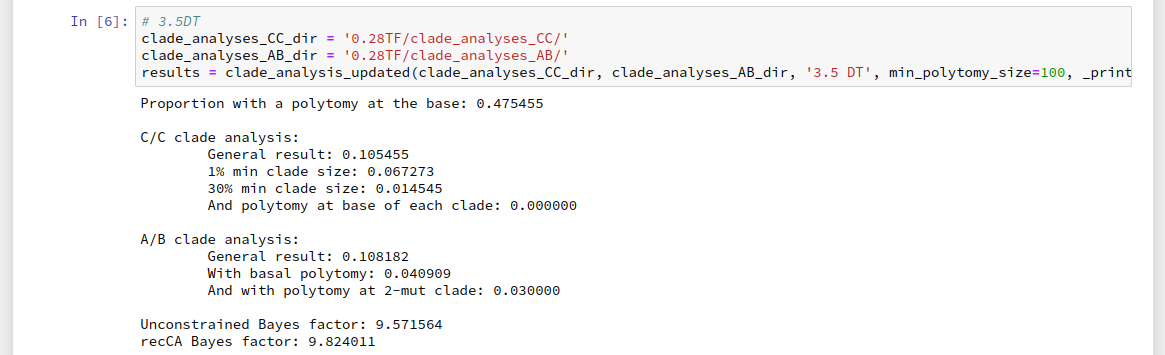

In [14]:
from IPython.display import Image
Image("../images/pubpeer-corrected-cladeAnalysis_result.png")

## Correction to calculate_bf

Codebase by Pekar et al. divides the simulation_results topology probabilities by their sum [increasing them according to the proportion of simulations that don't have a topology in this subset](https://github.com/nizzaneela/Programming_error_explanation) as explained [here](https://github.com/nizzaneela/Programming_error_explanation)

In [15]:
def calculate_bf_corrected(asr_results, simulation_results):
    # Let t_p be a polytomy, t_1C be one clade, and t_2c be two clades
    # trees are in the order
    # (t_p, t_1C, t_2C, (t_p,(t_p,t_1C,t_2C)), (t_1C,(t_p,t_1C,t_2C)), (t_2c,(t_p,t_1C,t_2C)))
    compatibility_matrix = np.array([np.array([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]), \
                                     np.array([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]),  \
                                     np.array([0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]),  \
                                     np.array([0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0])]  \
                                    )
    # A matrix of conditional probabilities
    # Each row stores the vector Pr(S_MRCA | \btau)
    pr_s_mrca_given_tree = compatibility_matrix.T
    pr_s_mrca_given_tree = np.array([x/sum(x) if sum(x) > 0 else x for x in pr_s_mrca_given_tree]) # if tree not associated with any haplotype, just keep the row as all 0s
    
    # Order: S_A, S_B, S_{C/C}, S_{T/T}
    pr_s_mrca_given_data = np.array(asr_results)/sum(asr_results)
    unnormalized_pr_data_given_s_mrca = pr_s_mrca_given_data.copy()
    
    # FAVITES simulation information
    # the 3 trees are in the order (t_p, t_1C, t_2C)
    ####### pr_3_topos has been changed to remove the division by sum of simulation results in line below ######
    pr_3_topos = np.array(simulation_results)
    pr_trees_given_I1 = np.concatenate([pr_3_topos, np.array([0]*9)])
    pr_trees_given_I2 = np.concatenate([np.array([0]*3), np.outer(pr_3_topos, pr_3_topos).flatten()])
    
    # Equal prior probability of 1 or 2 intros
    pr_I1 = 0.5
    pr_I2 = 0.5
    
    pr_s_mrca_and_I1 = np.dot([np.dot(pr_s_mrca_given_tree.T[i], pr_trees_given_I1) for i in range(0,4)], pr_I1) # dot product of P(haplotype|tree) (column) and P(trees|I_n), scaled by P(I_n)
    pr_s_mrca_and_I2 = np.dot([np.dot(pr_s_mrca_given_tree.T[i], pr_trees_given_I2) for i in range(0,4)], pr_I2)
    
    posterior_odds = np.dot(unnormalized_pr_data_given_s_mrca, pr_s_mrca_and_I2) / np.dot(unnormalized_pr_data_given_s_mrca, pr_s_mrca_and_I1)
    prior_odds = pr_I2/pr_I1
    BF = posterior_odds/prior_odds

    return(BF)

In [16]:
def clade_analysis_bf_corrected(clade_analyses_CC_dir, clade_analyses_AB_dir, label, min_polytomy_size=100, _print_=False):
    
    # C/C analyses focus on 1-mutation clades
    # therefore, all descendant lineages are included:
    #   -1 = unmutated leaf
    #    1 = mutated leaf separate from a clade
    #   >1 = clade
    clade_analyses_CC_d = dict()
    assert len(os.listdir(clade_analyses_CC_dir))>0, f"no files in {clade_analyses_CC_dir}" 
    for path in sorted(os.listdir(clade_analyses_CC_dir)): # pool all C/C clade analyses together 
        clade_analysis_path = clade_analyses_CC_dir + path
        key = path.split('_')[0]
        clade_analyses_CC_d[key] = {'clade_sizes': [], 'subclade_sizes': []}
        assert os.path.isfile(clade_analysis_path), f"{clade_analysis_path} doesn't exist" 
        for line in open(clade_analysis_path):
            l = line.strip().strip(']').split('[')
            clade_size = int(l[0].strip()) # make each clade size (including single leaves) an integer
            subclade_sizes = [int(x) for x in l[1].strip().replace(' ', '').split(',')] # put each subclade size (including single leaves) into a list        
            clade_analyses_CC_d[key]['clade_sizes'].append(clade_size)
            clade_analyses_CC_d[key]['subclade_sizes'].append(subclade_sizes)
    clade_analyses_CC_d = {int(k):clade_analyses_CC_d[k] for k in clade_analyses_CC_d}    

    # A/B analyses focus on 2-mutation clades
    # only 2-mutation clades are included 
    clade_analyses_AB_d = dict()
    for path in sorted(os.listdir(clade_analyses_AB_dir)): # pool all A/B clade analyses together 
        clade_analysis_path = clade_analyses_AB_dir + path
        key = path.split('_')[0]
        clade_analyses_AB_d[key] = {'clade_sizes': [], 'subclade_sizes': []}
        for line in open(clade_analysis_path):
            l = line.strip().strip(']').split('[')
            clade_size = int(l[0].strip()) # make each clade size (including single leaves) an integer
            subclade_sizes = [int(x) for x in l[1].strip().replace(' ', '').split(',')] # put each subclade size (including single leaves) into a list        
            clade_analyses_AB_d[key]['clade_sizes'].append(clade_size)
            clade_analyses_AB_d[key]['subclade_sizes'].append(subclade_sizes)
    clade_analyses_AB_d = {int(k):clade_analyses_AB_d[k] for k in clade_analyses_AB_d}    
    
    
    # C/C analysis
    cc_count = 0 # how often are there only two 1-mutation clades and no other descendants from the root?
    cc_count_1perc = 0 # how often are there only two 1-mutation clades, each constituting more than 1% of taxa, and no other descendants from the root?
    cc_count_30perc = 0 # how often are there only two 1-mutation clades, each constituting more than 30% of taxa, and no other descendants from the root?
    cc_count_30perc_twoPolytomies = 0 # how often are there only two 1-mutation clades, each constituting more than 30% of taxa AND with a polytomy at the base of each clade, and no other descendants from the root?
    for run in clade_analyses_CC_d:
        clade_sizes = clade_analyses_CC_d[run]['clade_sizes'].copy()
        subclade_sizes = [len(x)>=min_polytomy_size for x in clade_analyses_CC_d[run]['subclade_sizes'].copy()]
        if len(clade_sizes) == 2: # if there are more than two descendants, including individual leaves, skip
            if sum([clade_size > 1 for clade_size in clade_sizes]) == 2: # make sure each clade is an actual clade
                cc_count += 1
                if min(clade_sizes) > (sum(clade_sizes)*0.01): # make sure each clade is >1%
                    cc_count_1perc += 1
                if min(clade_sizes) > (sum(clade_sizes)*0.30): # make sure each clade is >30%
                    cc_count_30perc += 1
                    # does the clade have a polytomy at the base? 
                    if False not in subclade_sizes:
                        cc_count_30perc_twoPolytomies += 1
    
    # A/B analysis
    ab_count_30perc = 0 # interested in 2 mutations clade that are at least 30% of all taxa
    ab_count_30perc_polytomy = 0 # interested in 2 mutations clade that are at least 30% of all taxa + has a basal polytomy
    ab_count_30perc_twoPolytomies = 0 # interested in 2 mutations clade that are at least 30% of all taxa + has a basal polytomy + polytomy at 2 mutation clade
    lower_constraint = 0.3 # the 2-mutation clade must be at least 30% of all taxa
    upper_constraint = 0.7 # the 2-mutation clade must be at most 70% of all taxa
    
    for run in clade_analyses_AB_d:
        num_leaves = sum(clade_analyses_CC_d[run]['clade_sizes'])
        base_polytomy_size = len(clade_analyses_CC_d[run]['clade_sizes'])
        clade_sizes = clade_analyses_AB_d[run]['clade_sizes']
        ####### CC has been changed to AB in the line below###########################    
        subclade_sizes = clade_analyses_AB_d[run]['subclade_sizes'].copy()
        if not clade_sizes: # no 2 mutation clades
            continue
        if max(clade_sizes) >= lower_constraint*num_leaves and max(clade_sizes) <= upper_constraint*num_leaves: # clades match size restrictions
            if len(clade_sizes) == 1:
                ab_count_30perc += 1
                if base_polytomy_size >= min_polytomy_size: # basal polytomy
                    ab_count_30perc_polytomy += 1
                    if len(subclade_sizes[0]) >= min_polytomy_size: # two-mutation clade has polytomy
                        ab_count_30perc_twoPolytomies += 1
            else:
                clade2 = sorted(clade_sizes, reverse=True)[1]
                ab_count_30perc += 1
                if base_polytomy_size >= min_polytomy_size: # basal polytomy
                    ab_count_30perc_polytomy += 1
                    max2mutCladeLoc = clade_sizes.index(max(clade_sizes))
                    if len(subclade_sizes[max2mutCladeLoc]) >= min_polytomy_size: # two mutation clade has polytomy
                        ab_count_30perc_twoPolytomies += 1

    # polytomy: checking if there is a polytomy at the base of the tree; can do this using the C/C analysis
    min_polytomy_descendants = min_polytomy_size
    count_atLeastMinDescendants = 0
    for run in clade_analyses_CC_d:
        clade_sizes = clade_analyses_CC_d[run]['clade_sizes']
        if len(clade_sizes) >= min_polytomy_descendants: 
            count_atLeastMinDescendants += 1
    polytomy_result = count_atLeastMinDescendants/1100
    
    # calculate bayes factors
    cc_result = cc_count_30perc_twoPolytomies/1100
    ab_result = ab_count_30perc_twoPolytomies/1100
    constraint_text = 'Primary'

    simulation_results = [polytomy_result, ab_result, cc_result]
    unconstrained_results = np.array([1.68, 80.85, 10.32, 0.92])/100 # linA, linB, C/C, T/T
    recCA_results = np.array([77.28, 8.18, 10.49, 3.71])/100 # linA, linB, C/C, T/T
    bf_unconstrained = calculate_bf_corrected(unconstrained_results, simulation_results)
    bf_recCA = calculate_bf_corrected(recCA_results, simulation_results)
    
    if _print_ == True:
        print('Proportion with a polytomy at the base: %f\n' % (count_atLeastMinDescendants/1100))
        print('C/C clade analysis: \n\tGeneral result: %f\n\t1%% min clade size: %f\n\t30%% min clade size: %f\n\tAnd polytomy at base of each clade: %f\n' % (cc_count/1100, cc_count_1perc/1100, cc_count_30perc/1100, cc_count_30perc_twoPolytomies/1100))
        print('A/B clade analysis:\n\tGeneral result: %f\n\tWith basal polytomy: %f\n\tAnd with polytomy at 2-mut clade: %f\n' % (ab_count_30perc/1100, ab_count_30perc_polytomy/1100, ab_count_30perc_twoPolytomies/1100))
        print('Unconstrained Bayes factor: %f' % bf_unconstrained)
        print('recCA Bayes factor: %f' % bf_recCA)

    return [label, min_polytomy_size, "{:.1f}".format(cc_result*100), "{:.1f}".format(ab_result*100), "{:.1f}".format(polytomy_result*100), "{:.1f}".format(bf_unconstrained), "{:.1f}".format(bf_recCA)]
    

In [17]:
results = clade_analysis_bf_corrected(clade_analyses_CC_dir, clade_analyses_AB_dir, '3.5 DT', min_polytomy_size=100, _print_=True)

Proportion with a polytomy at the base: 0.475455

C/C clade analysis: 
	General result: 0.105455
	1% min clade size: 0.067273
	30% min clade size: 0.014545
	And polytomy at base of each clade: 0.000000

A/B clade analysis:
	General result: 0.108182
	With basal polytomy: 0.040909
	And with polytomy at 2-mut clade: 0.030000

Unconstrained Bayes factor: 4.837991
recCA Bayes factor: 4.965591
